## Positive Linear RNN doing 2 Freqs

Does it modularise when we think it should?

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
from mpl_toolkits.mplot3d import Axes3D
import math
import optax

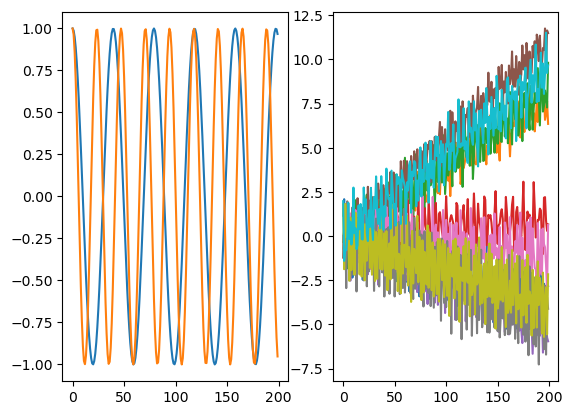

In [109]:
T = 200
freqs = [1, 1.676459674]
N = 10

num_freqs = len(freqs)

targets = np.zeros([num_freqs, T])
for freq_ind in range(num_freqs):
    targets[freq_ind,:] = np.cos(freqs[freq_ind]*np.arange(T)/(2*np.pi))

plt.subplot(1,2,1)
plt.plot(targets.T)

W = np.random.normal(0,1, [N,N])
W, S, V = np.linalg.svd(W) # Initialise with orthogonal matrix
g_0 = np.random.normal(0,1, [N,])
biases = np.random.normal(0,1, [N,])*0.1

params = {'W': W, 'g_0': g_0, 'biases':biases}

@jit
def generate_rep(params):
    g = jnp.zeros([N, T])
    g = g.at[:,0].set(params["g_0"])
    for t in range(1,T):
        g = g.at[:,t].set(params["W"]@g[:,t-1] + params["biases"])
    return g

plt.subplot(1,2,2)
plt.plot(generate_rep(params).T)

In [118]:
@jit
def loss_pos(g):
    g_neg = (g - jnp.abs(g))/2
    L_pos = -jnp.sum(g_neg)
    return L_pos

@jit
def loss_act(g):
    return jnp.sum(jnp.power(g, 2))

@jit
def loss_weight(W):
    return jnp.sum(jnp.power(W, 2))

@jit
def generate_R(g, targets):
    g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
    mat0 = jnp.matmul(g_bias, g_bias.T)
    mat1 = jnp.matmul(g_bias, targets.T)
    mat2 = jnp.matmul(jnp.linalg.inv(mat0 + 0.0001*jnp.eye(N+1)), mat1)
    return mat2

@jit
def loss_R(R, targets):
    return jnp.linalg.norm(generate_R(g, targets))**2

@jit
def loss_fit(g, R, targets):
    g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
    preds = R.T@g_bias
    #preds_demeaned = preds - np.mean(preds, axis = 1)[:,None]
    return jnp.linalg.norm(targets - preds)

mu_fit = 10000
mu_G = 1
mu_W = 1
mu_R = 1
mu_pos = 1000
fit_thresh = 0.01

@jit
def loss(params, targets):
    g = generate_rep(params)
    R = generate_R(g, targets)
    
    return mu_fit*jnn.relu(loss_fit(g, R, targets)-fit_thresh) + mu_G*loss_act(g) + mu_W*(loss_weight(params["W"])+loss_weight(params["g_0"])) + mu_R*loss_weight(R) + mu_pos*loss_pos(g)

@jit
def update(params, targets, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, targets)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

random_seed = 4363131
learning_rate = 1e-5

re_init = 0
if re_init:
    key = random.PRNGKey(random_seed)
    W = random.normal(key, (N,N))*0.001
    W, S, V = jnp.linalg.svd(W)
    g0 = random.normal(key, (N, ))*0.001
    biases = random.normal(key, (N,))*0.001
    optimizer = optax.adam(learning_rate)
    # Obtain the `opt_state` that contains statistics for the optimizer.
    params = {'W': W, 'g_0': g_0, 'biases':biases}
    opt_state = optimizer.init(params)

print(loss(params, targets))
min_loss = np.infty

1377.7804


In [119]:
grad_steps = 1000000
print_iter = 10000

for t in range(grad_steps):
    params, opt_state, loss = update(params, targets, opt_state)

    if t % print_iter == 0:
        g = generate_rep(params)
        R = generate_R(g, targets)

        L_f = loss_fit(g, R, targets)
        L_a = loss_act(g)
        L_w = loss_weight(params["W"])
        L_R = loss_weight(R)
        L_p = loss_pos(g)
        print(f"Step {t}, Loss: {loss:.5f}, Fit: {L_f:.5f}, Act: {L_a:.5f}, Wei: {L_w:.5f}, R: {L_R:.5f}, Pos: {L_p:.5f}")
        #print(f"Step {t}, Loss: {loss:.5f}")#, Fit: {L_f:.5f}, Act: {L_a:.5f}, Wei: {L_w:.5f}, R: {L_R:.5f}, Pos: {L_p:.5f}, PI: {L_PI:.5f}")

        min_this_step = 0

    if loss < min_loss:
        params_best = params
        min_loss = loss
        if min_this_step == 0:
            print(f'New min! {loss}')
            min_this_step = 1

Step 0, Loss: 1377.78040, Fit: 0.12088, Act: 60.70449, Wei: 7.59997, R: 51.29701, Pos: 0.00022
New min! 1377.7803955078125
Step 10000, Loss: 2134.14624, Fit: 0.14617, Act: 61.40471, Wei: 7.62050, R: 54.84552, Pos: -0.00000
New min! 126.51490783691406
Step 20000, Loss: 1628.62085, Fit: 0.14594, Act: 60.70669, Wei: 7.64853, R: 52.48274, Pos: -0.00000
Step 30000, Loss: 2848.86841, Fit: 0.06266, Act: 57.85871, Wei: 7.67654, R: 52.06188, Pos: -0.00000
Step 40000, Loss: 962.74127, Fit: 0.34068, Act: 60.89299, Wei: 7.71117, R: 57.06774, Pos: -0.00000
Step 50000, Loss: 2508.60205, Fit: 0.23180, Act: 62.80495, Wei: 7.75680, R: 49.91424, Pos: -0.00000
Step 60000, Loss: 2273.50562, Fit: 0.22915, Act: 58.28898, Wei: 7.80895, R: 59.51145, Pos: -0.00000
New min! 119.47992706298828
Step 70000, Loss: 1739.36780, Fit: 0.15577, Act: 58.92838, Wei: 7.87277, R: 53.67657, Pos: -0.00000
Step 80000, Loss: 1498.99292, Fit: 0.15329, Act: 60.72021, Wei: 7.96988, R: 48.57143, Pos: 0.00774
Step 90000, Loss: 1178.

KeyboardInterrupt: 

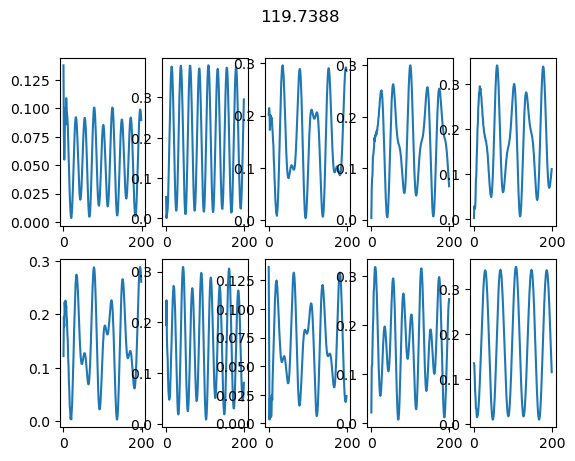

In [116]:
g_best = generate_rep(params_best)

for n in range(N):
    plt.subplot(2,5,1+n)
    plt.plot(g_best[n,:])
plt.suptitle(min_loss)

frequencies = np.zeros([num_freqs*2, T])
for freq_ind in range(num_freqs):
    frequencies[2*freq_ind,:] = np.cos(freqs[freq_ind]*np.arange(T)/(2*np.pi))
    frequencies[2*freq_ind+1,:] = np.sin(freqs[freq_ind]*np.arange(T)/(2*np.pi))


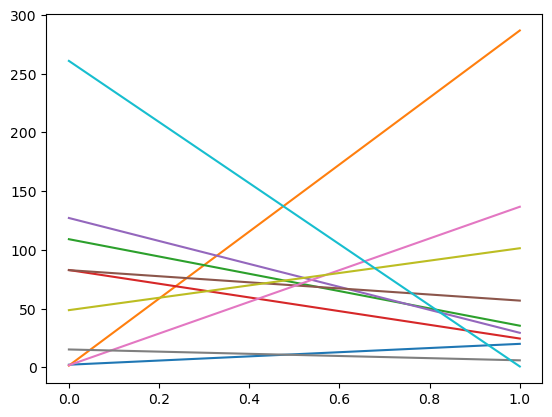

In [117]:
dot_prod = g_best@frequencies.T
mag = dot_prod**2
mag_per_freq = mag[:,::2] + mag[:,1::2]

plt.plot(mag_per_freq.T)

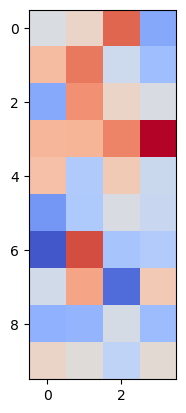

In [64]:
dot_prod = g_best@frequencies.T
plt.imshow(dot_prod, cmap = 'coolwarm')
color_val = np.max(np.abs(dot_prod))
plt.clim([-color_val, color_val])

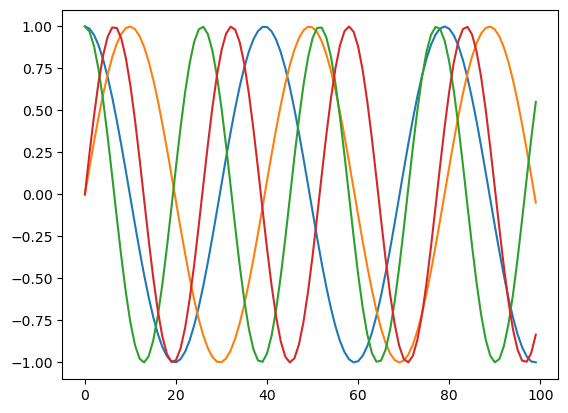

In [53]:
plt.plot(frequencies.T)

In [49]:
frequencies.shape

(4, 1000000)